In [ ]:
!pip install tensorflow_addons
from segnet import SegNet
from sequence import FoodSequence
import tensorflow as tf
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 686kB 6.8MB/s 


In [ ]:
!pip install -U aicrowd-cli
API_KEY = "67587f4b3488144e75864045bf9db5e9" #get your api-key from https://www.aicrowd.com/participants/me

!aicrowd login --api-key $API_KEY 
!aicrowd dataset download --challenge food-recognition-challenge 3 4 5
!tar -zxvf train-v0.4.tar.gz

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 174kB 8.2MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 215kB 8.5MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


Streaming output truncated to the last 5000 lines.
./train/images/016635.jpg
./train/images/084765.jpg
./train/images/030078.jpg
./train/images/095272.jpg
./train/images/074596.jpg
./train/images/068251.jpg
./train/images/021057.jpg
./train/images/098101.jpg
./train/images/094285.jpg
./train/images/007293.jpg
./train/images/099408.jpg
./train/images/019538.jpg
./train/images/049791.jpg
./train/images/021889.jpg
./train/images/075978.jpg
./train/images/043050.jpg
./train/images/077428.jpg
./train/images/026325.jpg
./train/images/008192.jpg
./train/images/082412.jpg
./train/images/013239.jpg
./train/images/028513.jpg
./train/images/084736.jpg
./train/images/076279.jpg
./train/images/103474.jpg
./train/images/070743.jpg
./train/images/071644.jpg
./train/images/095290.jpg
./train/images/037048.jpg
./train/images/009347.jpg
./train/images/078783.jpg
./train/images/084642.jpg
./train/images/032499.jpg
./train/images/099724.jpg
./train/images/079743.jpg
./train/images/074193.jpg
./train/image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def precision(mask, y_pred, threshold=0.6):
  y = y_pred > threshold
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y, axis=[1, 2])
  true_positive = tf.math.count_nonzero(tf.boolean_mask(real_cats, cats))
  tp_plus_fp = tf.math.count_nonzero(cats)
  if tp_plus_fp == 0:
    return tf.cast(0, dtype=tf.float64);
  return true_positive / tp_plus_fp

In [ ]:
def IoU(mask, y_pred, threshold=0.6):
  y = y_pred > threshold
  intersection = tf.math.count_nonzero(tf.boolean_mask(y, mask))
  union = tf.math.count_nonzero(mask + tf.cast(y, dtype=tf.float32))
  return  intersection / union

In [ ]:
def precisionWithIoU(mask, y_pred, threshold_max=0.77, threshold=0.4):
  y_max = y_pred > threshold_max
  y = y_pred > threshold 
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  number_of_prediction = tf.math.count_nonzero(cats)
  if number_of_prediction == 0:
    return tf.cast(0, dtype=tf.float64)

  intersections = tf.math.count_nonzero(tf.logical_and(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  unions = tf.math.count_nonzero(tf.logical_or(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  ious = intersections / unions
  predicted_cats = tf.logical_and(ious > 0.5, cats)
  true_positive = tf.math.count_nonzero(tf.logical_and(real_cats, predicted_cats))

  return true_positive / number_of_prediction
  

In [ ]:
def true_positive(mask, y_pred, threshold_max=0.77, threshold=0.4):
  y_max = y_pred > threshold_max
  y = y_pred > threshold 
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y_max, axis=[1, 2])

  intersections = tf.math.count_nonzero(tf.logical_and(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  unions = tf.math.count_nonzero(tf.logical_or(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  ious = intersections / unions
  predicted_cats = tf.logical_and(ious > 0.5, cats)

  return tf.math.count_nonzero(tf.logical_and(real_cats, predicted_cats))

def true_negative(mask, y_pred, threshold_max=0.77, threshold=0.4):
  y_max = y_pred > threshold_max
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  true_negative_chan = tf.logical_not(tf.logical_or(cats, real_cats))
  return tf.math.count_nonzero(true_negative_chan)

def false_positive(mask, y_pred, threshold_max=0.77, threshold=0.4):
  y_max = y_pred > threshold_max
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  return tf.math.count_nonzero(cats) - true_positive(mask, y_pred, threshold_max, threshold)

def false_negative(mask, y_pred, threshold_max=0.77, threshold=0.4):
  y_max = y_pred > threshold_max
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  return tf.math.count_nonzero(tf.logical_not(cats)) - true_negative(mask, y_pred, threshold_max, threshold)

In [ ]:
file = open("train/annotations.json", "r")
annotations = json.loads(file.read())

ann = pd.DataFrame(annotations['annotations'])
mapping = {item:i for i, item in enumerate(ann["category_id"].unique())}
categories = pd.DataFrame(annotations['categories'])
categories['id'] = categories['id'].apply(lambda x: mapping[x])
categories = categories.set_index('id')

file_ = open("val/annotations.json", "r")
annotations = json.loads(file_.read())

ann = pd.DataFrame(annotations['annotations'])
ann["category_id"] = ann["category_id"].apply(lambda x: mapping[x])
annotations_map = {img_id: {} for img_id in ann['image_id'].unique()}
for index, row in ann.iterrows():
    annotations_map[row['image_id']][row['category_id']] = row['segmentation']
images = pd.DataFrame(annotations['images'])
images = images.set_index('id')

np.random.seed(0)
msk = np.random.rand(len(images)) < 0.5
val_images = images[msk]
test_images = images[~msk]

val_set = FoodSequence(val_images, annotations_map, len(categories), batch_size=1, folder='val',img_size=(256, 256), data_augmentation=False)
test_set = FoodSequence(test_images, annotations_map, len(categories), batch_size=1, folder='val',img_size=(256, 256), data_augmentation=False)

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/challenge/models/segnet/model140', custom_objects={"SegNet": SegNet}, compile=False)
model.compile(
    metrics=[true_positive, false_positive, true_negative, false_negative]
  )
model.evaluate(test_set)

620/620 [==============================] - 1227s 2s/step - loss: 0.0000e+00 - true_positive: 0.3226 - false_positive: 3.3306 - true_negative: 268.1097 - false_negative: 1.2371


[0.0,
 0.32258063554763794,
 3.3306450843811035,
 268.10968017578125,
 1.2370967864990234]

In [ ]:
from functools import partial

ths = [0.39, 0.395, 0.4, 0.405, 0.41]
ious = []

for threshold in ths:
  model.compile(metrics=partial(precisionWithIoU, threshold=threshold))
  results = model.evaluate(val_set)
  ious.append(results[1])

649/649 [==============================] - 1209s 2s/step - loss: 0.0000e+00 - partial: 0.0972


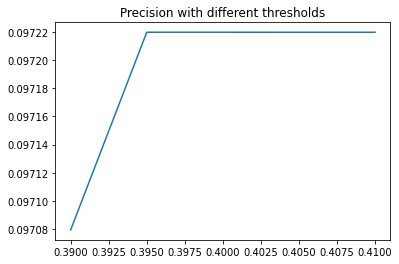

In [ ]:
plt.plot(ths, ious);
plt.title("Precision with different thresholds");

In [ ]:
def desired_output(img_shape, segmentations):
        desired_output = np.zeros((img_shape[0], img_shape[1], len(categories)), dtype=np.int32)

        for i in segmentations:
          t = np.zeros((img_shape[0], img_shape[1], 1), dtype=np.int32)
          for seg in segmentations[i]:
              s = np.array(seg, dtype=np.int32).reshape((-1, 2))
              t = cv2.fillPoly(t, [s], 255)

          desired_output[:, :, i] = t.squeeze()

        return desired_output / 255

Sample n° 16835
IoU:  tf.Tensor(0.11895072591289045, shape=(), dtype=float64)


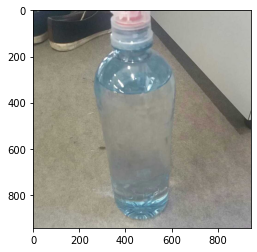

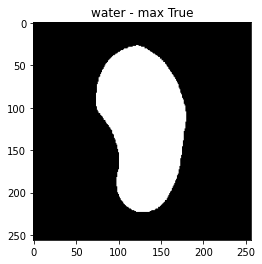

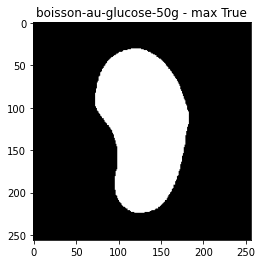

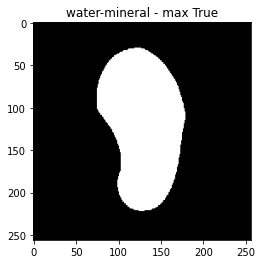

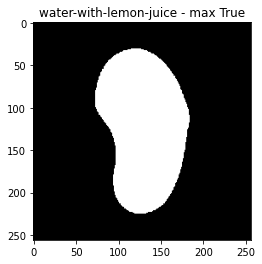

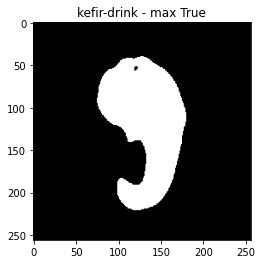

In [ ]:
threshold = 0.58
img_id = val_images.sample().index.values[0]
print("Sample n°", img_id)
img = cv2.imread('val/images/' + val_images.loc[img_id, 'file_name'])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

input_img = cv2.resize(img, dsize=(256, 256)) / 255
y = model.predict(input_img.reshape((1, input_img.shape[0], input_img.shape[1], input_img.shape[2])))

img_ann = ann[ann['image_id'] == img_id]
segmentations = dict(zip(img_ann['category_id'], img_ann['segmentation']))
y_true = desired_output(img.shape, segmentations)
y_true = cv2.resize(y_true, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)

print("IoU: ", IoU(y_true, y[0], threshold=threshold))

y = y > threshold
for i in range(len(categories)):
  if np.any(y[0, :, :, i]):
    fig = plt.figure()
    plt.title(categories.iloc[i]['name'] + " - max " + str(np.max(y[0, :, :, i])))
    plt.imshow(y[0, :, :, i], cmap='gray', vmin=0, vmax=1)